## An example geography with two islands

Let's evaluate the accuracy of the waypoints model using two island simulation and hex-grid waypoints.

We'll use the real times of ancestral nodes in the graph so that we only have to infer the location of ancestors.

In [8]:
import matplotlib.pyplot as plt
import torch
import sys
sys.path.insert(0, "..")
from tspyro.diffusion import make_hex_grid
import tspyro
import tsdate
import pyslim
import numpy as np

In [2]:
import tskit

# Draw islands
Create the island model, output greyscale for SLiMGui to read in.

In [3]:
# Global Variables for Islands Geography
bounds = dict(west=0, east=4.0, south=0, north=2.24)
island_center = [(1.33, 1.2), (2.66, 1.2)]
island_radius = [0.33, 0.33]

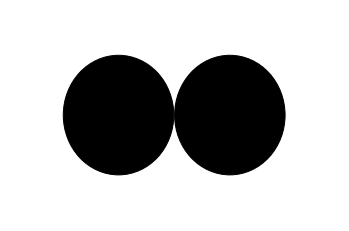

In [4]:
circle1 = plt.Circle(island_center[0], island_radius[0] * 2, color='black')
circle2 = plt.Circle(island_center[1], island_radius[1] * 2, color='black')

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()
plt.xlim(0, 4)
plt.ylim(0, 2.4)

ax.add_patch(circle1)
ax.add_patch(circle2)
plt.axis("off")
plt.savefig("close_islands.png")
from PIL import Image
Image.open('close_islands.png').convert('L').save('close_islands.png')

In [5]:
ts = pyslim.load("/Users/awohns/Desktop/close_islands.trees").simplify()
recap_ts = ts.recapitate(recombination_rate=1e-8, Ne=50).simplify()

In [9]:
# Get the real locations of nodes

lat_long = []
for node in recap_ts.nodes():
    if node.individual != -1:
        ind = recap_ts.individual(node.individual)
    
        lat_long.append([ind.location[0], ind.location[1]])
    else:
        print(node)
lat_long = np.array(lat_long)

Node(id=3615, flags=0, time=2026.0981172405134, population=0, individual=-1, metadata=None)
Node(id=3616, flags=0, time=2055.047873975296, population=0, individual=-1, metadata=None)


(0.0, 2.0)

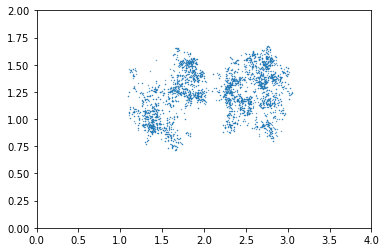

In [10]:
# Plot the real locations of nodes
plt.scatter(lat_long[:,0], lat_long[:,1], s=0.1)
plt.xlim(0, 4)
plt.ylim(0, 2)

In [11]:
# Match waypoints to model from above
grid_radius = 0.1

def on_land(x, y):
    result = torch.tensor(False)
    for (x0, y0), r in zip(island_center, island_radius):
        result = result | (r > (x - x0) ** 2 + (y - y0) ** 2)
    return result

In [12]:
grid = make_hex_grid(**bounds, radius=grid_radius, predicate=on_land)
waypoints = grid["waypoints"]
transition = grid["transition"]

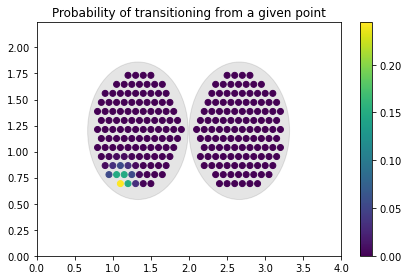

In [13]:
plt.title("Probability of transitioning from a given point")
plt.scatter(waypoints[:, 0], waypoints[:, 1], c=transition[0])
plt.xlim(bounds["west"], bounds["east"])
plt.ylim(bounds["south"], bounds["north"])
# Add islands in background
circle1 = plt.Circle(island_center[0], island_radius[0] * 2, color='black', alpha=0.1, zorder=-1)
circle2 = plt.Circle(island_center[1], island_radius[1] * 2, color='black', alpha=0.1, zorder=-1)
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)

# plt.axis("equal")
plt.colorbar()
plt.tight_layout()

And note the spread of lineages is roughly covered by the waypoints

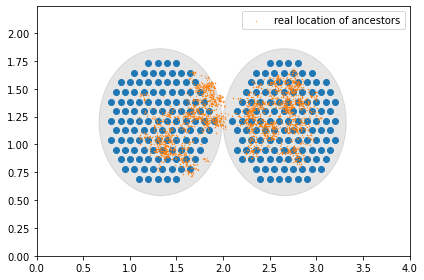

In [16]:
plt.scatter(waypoints[:, 0], waypoints[:, 1])
plt.xlim(bounds["west"], bounds["east"])
plt.ylim(bounds["south"], bounds["north"])
circle1 = plt.Circle(island_center[0], island_radius[0] * 2, color='black', alpha=0.1, zorder=-1)
circle2 = plt.Circle(island_center[1], island_radius[1] * 2, color='black', alpha=0.1, zorder=-1)
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.tight_layout()
plt.scatter(lat_long[:,0], lat_long[:,1], s=0.1, label="real location of ancestors")
plt.legend()

For fun, let's find a lineage that "jumps" between islands.
But curiously, there don't seem to be any.

In [17]:
# NOTE: could tune distance between two islands until see jumpes
migrants = set()
for tree in recap_ts.trees():
    for node in recap_ts.samples():
        locs = []
        while node != -1 and node < ts.num_nodes:
            locs.append(lat_long[node])
            node = tree.parent(node)
        locs = np.array(locs)
        if np.any(locs[:,0] < 2) and np.any(locs[:,0] > 2):
            migrants.add(node)

# Inference code

Let's now try to infer the location of ancestors.

The following code is messy, but some details are still to be worked out.
Obviously we'll want a simple interface for users to choose the browning motion model or waypoint model, and will want to implement this without duplicating code. Q: how should we organise the code for this?

In [18]:
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import Trace_ELBO, SVI
from pyro.infer.autoguide import AutoDelta, AutoNormal
from pyro.optim import Adam
from pyro.nn import PyroModule
from pyro.infer.reparam import LocScaleReparam

from pyro.distributions import constraints, TorchDistribution
from torch.distributions.utils import broadcast_all

from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 120

import numpy as np

import sklearn
from sklearn.metrics import mean_squared_log_error, mean_squared_error

torch.set_default_dtype(torch.double)

In [19]:
import math

class NaiveModel(PyroModule):
    def __init__(self, ts, *, Ne, prior, transitions, waypoints, waypoint_radius,
               node_times=None, leaf_location=None, mutation_rate=1e-8, penalty=100.):
        super().__init__()
        nodes = ts.tables.nodes
        edges = ts.tables.edges
        self.is_leaf = torch.tensor((nodes.flags & 1).astype(bool), dtype=torch.bool)
        self.is_internal = ~self.is_leaf
        self.num_nodes = len(self.is_leaf)
        self.num_internal = self.is_internal.sum().item()

        self.ts = ts

        self.parent = torch.tensor(edges.parent, dtype=torch.long)
        self.child = torch.tensor(edges.child, dtype=torch.long)
        self.span = torch.tensor(edges.right - edges.left, dtype=torch.float)
        self.mutations = torch.tensor(self.get_mut_edges(), dtype=torch.float) # this is an int, but we optimise with float for pytorch

        self.penalty = float(penalty)
        self.Ne = float(Ne)
        self.mutation_rate = mutation_rate

        self.node_times=node_times

        # conditional coalescent prior
        timepoints = torch.as_tensor(prior.timepoints, dtype=torch.float)
        timepoints = timepoints.mul(2*Ne).log1p()
        # timepoints = timepoints.clamp(min=0)
        grid_data = torch.as_tensor(prior.grid_data[:], dtype=torch.float)
        grid_data = grid_data / grid_data.sum(1, True)
        self.prior_loc = torch.einsum("t,nt->n", timepoints, grid_data)
        deltas = (timepoints - self.prior_loc[:,None]) ** 2
        self.prior_scale = torch.einsum("nt,nt->n", deltas, grid_data).sqrt()
        # self.prior_loc += math.log(Ne)

        # GEOGRAPHY
        self.leaf_location = leaf_location
        # Pass in the transition matrix and waypoints
        self.transition = transition
        self.waypoint_radius = waypoint_radius
        self.waypoints = waypoints
        # This cheaply precomputes some matrices.
        self.matrix_exp = tspyro.diffusion.ApproximateMatrixExponential(self.transition)

    def get_mut_edges(self):
        """
        Get the number of mutations on each edge in the tree sequence.
        """
        ts = self.ts
        edge_diff_iter = ts.edge_diffs()
        right = 0
        edges_by_child = {}  # contains {child_node:edge_id}
        mut_edges = np.zeros(ts.num_edges, dtype=np.int64)
        for site in ts.sites():
            while right <= site.position:
                (left, right), edges_out, edges_in = next(edge_diff_iter)
                for e in edges_out:
                    del edges_by_child[e.child]
                for e in edges_in:
                    assert e.child not in edges_by_child
                    edges_by_child[e.child] = e.id
            for m in site.mutations:
                # In some cases, mutations occur above the root
                # These don't provide any information for the inside step
                if m.node in edges_by_child:
                    edge_id = edges_by_child[m.node]
                    mut_edges[edge_id] += 1
        return mut_edges

    def forward(self):
        # First sample times from an improper uniform distribution which we denote
        # via .mask(False). Note only the internal nodes are sampled; leaves are
        # fixed at zero.
        # Note this isn't a coalescent prior, but some are available at:
        # https://docs.pyro.ai/en/stable/_modules/pyro/distributions/coalescent.html
        with pyro.plate("internal_nodes", self.num_internal):
            if self.node_times is None:
                internal_time = pyro.sample(
                "internal_time",
                # dist.Exponential(1).mask(False),
                dist.LogNormal(self.prior_loc, self.prior_scale).mask(True) # False turns off prior but uses it for initialisation
                ) # internal time is modelled in logspace
            else:
                internal_time = self.node_times[self.ts.num_samples:]
            # GEOGRAPHY.
            # Sample location from a flat prior, we'll add a pyro.factor statement later.
            internal_location = pyro.sample(
            "internal_location",
            dist.Normal(torch.zeros(2), torch.ones(2)).to_event(1).mask(False),
            )

        internal_time = internal_time
        time = torch.zeros((self.num_nodes,))
        time[self.is_internal] = internal_time
        # GEOGRAPHY.
        # Should we be Bayesian about migration scale, or should it be fixed?
        migration_scale = pyro.sample("migration_scale", dist.LogNormal(-5, 1))

        # Next add a factor for time gaps between parents and children.
        gap = time[self.parent] - time[self.child]

        with pyro.plate("edges", len(gap)):
            if self.node_times is None:
                rate = (gap * self.span * self.mutation_rate).clamp(min=1e-8)
                pyro.sample(
                "mutations",
                dist.Poisson(rate),
                obs=self.mutations,
                )
            else:
                time = self.node_times
            if self.leaf_location is not None:
                gap = gap.clamp(min=1e-10)
                # GEOGRAPHY.
                # The following encodes that children migrate away from their parents
                # following brownian motion with rate migration_scale.
                location = torch.cat([self.leaf_location, internal_location], 0)
                parent_location = location.index_select(0, self.parent)
                child_location = location.index_select(0, self.child)

                pyro.sample(
                    "migration",
                    tspyro.diffusion.WaypointDiffusion2D(
                        source=parent_location,
                        time=gap,
                        radius=self.waypoint_radius,
                        waypoints=self.waypoints,
                        matrix_exp=self.matrix_exp,
                    ),
                    obs=child_location,
                )
            else:
                location = torch.ones(self.ts.num_nodes)
        return time, gap, location, migration_scale

In [20]:
import itertools
import operator

def radians_center_weighted(x, y, z, weights):
    total_weight = np.sum(weights)
    weighted_avg_x = np.sum(weights * np.array(x)) / total_weight
    weighted_avg_y = np.sum(weights * np.array(y)) / total_weight
    weighted_avg_z = np.sum(weights * np.array(z)) / total_weight
    central_longitude = np.arctan2(weighted_avg_y, weighted_avg_x)
    central_square_root = np.sqrt(
        weighted_avg_x * weighted_avg_x + weighted_avg_y * weighted_avg_y
    )
    central_latitude = np.arctan2(weighted_avg_z, central_square_root)
    return central_latitude, central_longitude


def vectorized_weighted_geographic_center(lat_arr, long_arr, weights):
    lat_arr = np.radians(lat_arr)
    long_arr = np.radians(long_arr)
    x = np.cos(lat_arr) * np.cos(long_arr)
    y = np.cos(lat_arr) * np.sin(long_arr)
    z = np.sin(lat_arr)
    if len(weights.shape) > 1:
        total_weights = np.sum(weights, axis=1)
    else:
        total_weights = np.sum(weights)
    weighted_avg_x = np.sum(weights * x, axis=1) / total_weights
    weighted_avg_y = np.sum(weights * y, axis=1) / total_weights
    weighted_avg_z = np.sum(weights * z, axis=1) / total_weights
    central_longitude = np.arctan2(weighted_avg_y, weighted_avg_x)
    central_sqrt = np.sqrt((weighted_avg_x ** 2) + (weighted_avg_y ** 2))
    central_latitude = np.arctan2(weighted_avg_z, central_sqrt)
    return np.degrees(central_latitude), np.degrees(central_longitude)

def weighted_geographic_center(lat_list, long_list, weights):
    x = list()
    y = list()
    z = list()
    if len(lat_list) == 1 and len(long_list) == 1:
        return (lat_list[0], long_list[0])
    lat_radians = np.radians(lat_list)
    long_radians = np.radians(long_list)
    x = np.cos(lat_radians) * np.cos(long_radians)
    y = np.cos(lat_radians) * np.sin(long_radians)
    z = np.sin(lat_radians)
    weights = np.array(weights)
    central_latitude, central_longitude = radians_center_weighted(x, y, z, weights)
    return (np.degrees(central_latitude), np.degrees(central_longitude))

def get_parent_age(self, edge):
    times = self.ts.tables.nodes.time[:]
    return times[operator.attrgetter("parent")(edge)]

def edges_by_parent_age_asc(self):
    return itertools.groupby(self.ts.edges(), self.get_parent_age)

def edges_by_parent_asc(ts):
    """
    Return an itertools.groupby object of edges grouped by parent in ascending order
    of the time of the parent. Since tree sequence properties guarantee that edges
    are listed in nondecreasing order of parent time
    (https://tskit.readthedocs.io/en/latest/data-model.html#edge-requirements)
    we can simply use the standard edge order
    """
    return itertools.groupby(ts.edges(), operator.attrgetter("parent"))

def parents_in_epoch(parents):
    return itertools.groupby(parents, operator.attrgetter("parent"))

def edge_span(edge):
    return edge.right - edge.left

def average_edges(parent_edges, locations):
    parent = parent_edges[0]
    edges = parent_edges[1]

    child_spanfracs = list()
    child_lats = list()
    child_longs = list()

    for edge in edges:
        child_spanfracs.append(edge_span(edge))
        child_lats.append(locations[edge.child][0])
        child_longs.append(locations[edge.child][1])
    val = weighted_geographic_center(
        child_lats, child_longs, np.ones_like(len(child_lats))
    )
    return parent, val

def get_ancestral_geography(ts, sample_locations, show_progress=False):
  """
  Use dynamic programming to find approximate posterior to sample from
  """
  locations = np.zeros((ts.num_nodes, 2))
  locations[ts.samples()] = sample_locations
  fixed_nodes = set(ts.samples())

  # Iterate through the nodes via groupby on parent node
  for parent_edges in edges_by_parent_asc(ts):
      if parent_edges[0] not in fixed_nodes:
          parent, val = average_edges(parent_edges, locations)
          locations[parent] = val
  return torch.tensor(locations[ts.num_samples:])

In [21]:
from pyro.infer.autoguide import init_to_median

def date_pyro(ts, prior, transitions, waypoints, waypoint_radius,
              leaf_location=None, node_times=None, Ne=10000, mutation_rate=1e-8, steps=1001):
  
  pyro.set_rng_seed(20210518)
  pyro.clear_param_store()

  model = NaiveModel(ts, transitions=transitions, waypoints=waypoints, waypoint_radius=waypoint_radius,
                     leaf_location=leaf_location, node_times=node_times, prior=prior, Ne=Ne, mutation_rate=mutation_rate)

  # autoguide initialises location param, but we want a different initialiser for each pyro sample statement
  # if we wanted to initialise global params, then check 'if site["name"] == "global_param_name":'
  # (this is a property of the approx posterior, not model, hence it's here and not in forward())
  def init_loc_fn(site):
    if site["name"] == "internal_time":
      prior_init = np.einsum("t,nt->n", priors.timepoints, (priors.grid_data[:]))/np.sum(priors.grid_data[:], axis=1)
      internal_time = torch.as_tensor(prior_init, dtype=torch.double) #/ Ne
      return internal_time.clamp(min=0.1)
    # GEOGRAPHY.
    if site["name"] == "internal_location":
      initial_guess_loc = get_ancestral_geography(ts, leaf_location)#np.repeat([[10,10]], sample_ts.num_samples, axis=0))
      return initial_guess_loc
    return init_to_median(site) # automatic strategy (the default) if not "internal_time"
  # guide = AutoDelta(model) # Simple point estimate
  guide = AutoNormal(model, init_scale=0.01, init_loc_fn=init_loc_fn) # Mean field (fully Bayesian)
  # guide = pyro.infer.autoguide.AutoLowRankMultivariateNormal(model, init_scale=0.01)#, init_loc_fn=init_loc_fn) # bigger matricies means clipped adam works better
  # optim = Adam({"lr": 0.05})
  optim = pyro.optim.ClippedAdam({"lr": 0.02, "lrd": 0.1**(1/max(1, steps))}) # lrd (learning rate decay) decreases learning rate over num of steps from lr to lr * 0.01
  # optim = pyro.optim.ClippedAdam({"lr": 0.005})
  svi = SVI(model, guide, optim, Trace_ELBO())
  guide() # initialises the guide
  losses = []
  migration_scales = []
  for step in range(steps):
    loss = svi.step() / ts.num_nodes
    losses.append(loss)
    if step % 10 == 0:
      with torch.no_grad():
        median = guide.median() # assess convergence of migration scale parameter
        migration_scale = float(median["migration_scale"])
        migration_scales.append(migration_scale)
      print(f"step {step} loss = {loss:0.5g}, Migration scale= {migration_scale:0.3g}")
  fig, ax = plt.subplots(2, 1, figsize=(6,2))
  # plt.figure(figsize=(6,2))
  ax[0].plot(losses)
  ax[0].set_xlabel("SVI step")
  ax[0].set_ylabel("loss")
  ax[0].set_yscale("symlog")
  ax[1].plot(migration_scales)
  median = guide.median()
  pyro_time, gaps, location, migration_scale = poutine.condition(model, median)()
  return model, pyro_time, gaps, location, migration_scale, guide

In [24]:
priors = tsdate.build_prior_grid(recap_ts, Ne=10000, approximate_priors=True, timepoints=100, progress=True)


Assign Prior to Each Node: 100%|██████████| 1617/1617 [00:00<00:00, 1965.31it/s]


This next step is noticeably much slower when using waypoints, and the migration scale seems to grow monotonically. While the loss function decreases, and the results are worse than using the average of the child locations, is this something about the training rate? Or is something not parameterised correctly?

In [36]:
%%time
mutation_rate=1e-7
node_times = torch.as_tensor(recap_ts.tables.nodes.time, dtype=torch.double)
leaf_location=torch.as_tensor(
                                                  lat_long[:recap_ts.num_samples,:], dtype=torch.double)
model, pyro_dates, gaps, location, migration_scale, guide = date_pyro(recap_ts, priors,
                                                                      transition,
                                                                      waypoints,
                                                                      0.2,
                                              leaf_location=leaf_location,
                                              node_times=node_times,
                                              Ne=1000,
                                              steps=200, mutation_rate=mutation_rate)
                                              
# prior_dates, _, location_prior = model() # run the model to sample from the prior

RuntimeError: expected scalar type Double but found Float

In [26]:
average_location = get_ancestral_geography(recap_ts, lat_long[:recap_ts.num_samples])
average_location = np.concatenate([lat_long[:recap_ts.num_samples], average_location])

In [27]:
# Internal Node locations
real_locations_internal = lat_long[recap_ts.num_samples:,]
average_locations_internal = average_location[recap_ts.num_samples:,]
inferred_locations_internal = location[recap_ts.num_samples:,]

NameError: name 'location' is not defined

In [ ]:
plt.scatter(real_locations_internal[:,0], real_locations_internal[:,1], s=0.1)
plt.scatter(average_locations_internal[:,0], average_locations_internal[:,1], s=0.1)
# for real, predicted in zip(real_locations_internal, average_locations_internal):
#     plt.plot((real[0], predicted[0]), (real[1], predicted[1]), linewidth=0.1, color="grey")
# plt.title("Real vs. Predicted Locations: Average of Children Locations")

In [ ]:
plt.scatter(
    real_locations_internal[:,0], real_locations_internal[:,1], s=0.1, c="b", label="True Location")
plt.scatter(
    inferred_locations_internal[:,0],
    inferred_locations_internal[:,1], s=0.1, c="orange", label="Inferred Location")
X, Y = [], []
for real, predicted in zip(real_locations_internal.tolist(), inferred_locations_internal.tolist()):
    X.extend([real[0], predicted[0], None])
    Y.extend([real[1], predicted[1], None])
plt.plot(X, Y, linewidth=0.1, color="grey")

# Overlay the waypoints
plt.scatter(waypoints[:,0], waypoints[:,1], zorder=-1, alpha=0.1, color="grey")


Text(0, 0.5, 'Longitude')

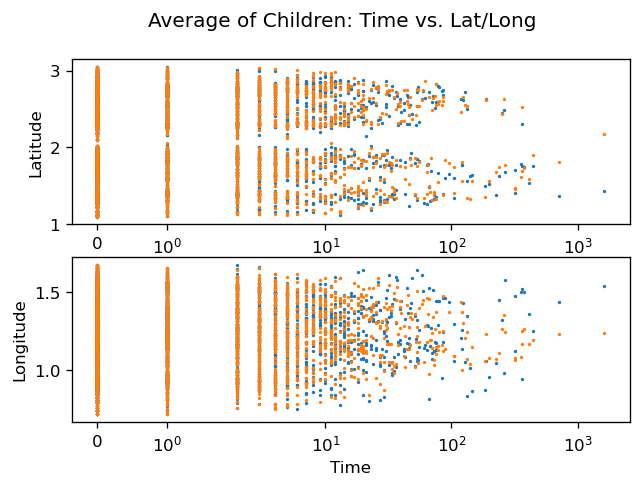

In [813]:
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].scatter(recap_ts.tables.nodes.time[:len(lat_long)], lat_long[:,0], s=1)
ax[0].scatter(recap_ts.tables.nodes.time[:len(lat_long)], average_location[:len(lat_long),0], s=1)
ax[1].scatter(recap_ts.tables.nodes.time[:len(lat_long)], lat_long[:,1], s=1)
ax[1].scatter(recap_ts.tables.nodes.time[:len(lat_long)], average_location[:len(lat_long),1], s=1)
fig.suptitle("Average of Children: Time vs. Lat/Long")
ax[0].set_xscale("symlog")
ax[1].set_xscale("symlog")
plt.xlabel("Time")
ax[0].set_ylabel("Latitude")
ax[1].set_ylabel("Longitude")


Text(0, 0.5, 'Latitude')

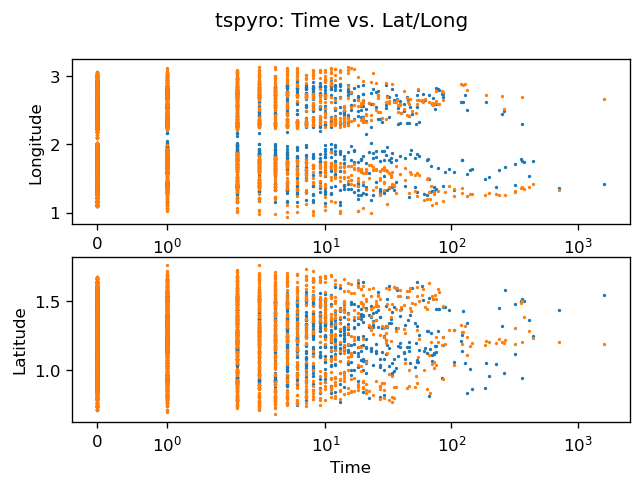

In [814]:
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].scatter(recap_ts.tables.nodes.time[:len(lat_long)], lat_long[:,0], s=1)
ax[0].scatter(recap_ts.tables.nodes.time[:len(lat_long)], location[:len(lat_long),0], s=1)
ax[1].scatter(recap_ts.tables.nodes.time[:len(lat_long)], lat_long[:,1], s=1)
ax[1].scatter(recap_ts.tables.nodes.time[:len(lat_long)], location[:len(lat_long),1], s=1)
fig.suptitle("tspyro: Time vs. Lat/Long")
ax[0].set_xscale("symlog")
ax[1].set_xscale("symlog")
plt.xlabel("Time")
ax[0].set_ylabel("Longitude")
ax[1].set_ylabel("Latitude")

In [815]:
average_location_scaled = sklearn.preprocessing.minmax_scale(average_location, feature_range=(0,1))
real_location_scaled = sklearn.preprocessing.minmax_scale(lat_long, feature_range=(0,1))
location_scaled = sklearn.preprocessing.minmax_scale(location, feature_range=(0,1))
print("Pyro Model:", mean_squared_error(real_location_scaled,
                                        location_scaled[:len(lat_long)]))
print("Average of children model:", mean_squared_error(real_location_scaled,
                                                       average_location_scaled[:len(lat_long)]))

Pyro Model: 0.0036064782478090543
Average of children model: 0.0009813140130120951


# Yan's empirical dispersal rate

In [16]:
ts.individual(500)

Individual(id=500, flags=262144, location=array([ 8.36580426e-001,  5.70109759e-001, -4.04480997e+307]), parents=array([], dtype=int32), nodes=array([1806], dtype=int32), metadata={'pedigree_id': 117, 'age': -1, 'subpopulation': 1, 'sex': -1, 'flags': 0})

In [17]:
ts.metadata

{'SLiM': {'file_version': '0.6',
  'generation': 2000,
  'model_type': 'WF',
  'nucleotide_based': False,
  'separate_sexes': False,
  'spatial_dimensionality': 'xy',
  'spatial_periodicity': '',
  'stage': 'late'}}

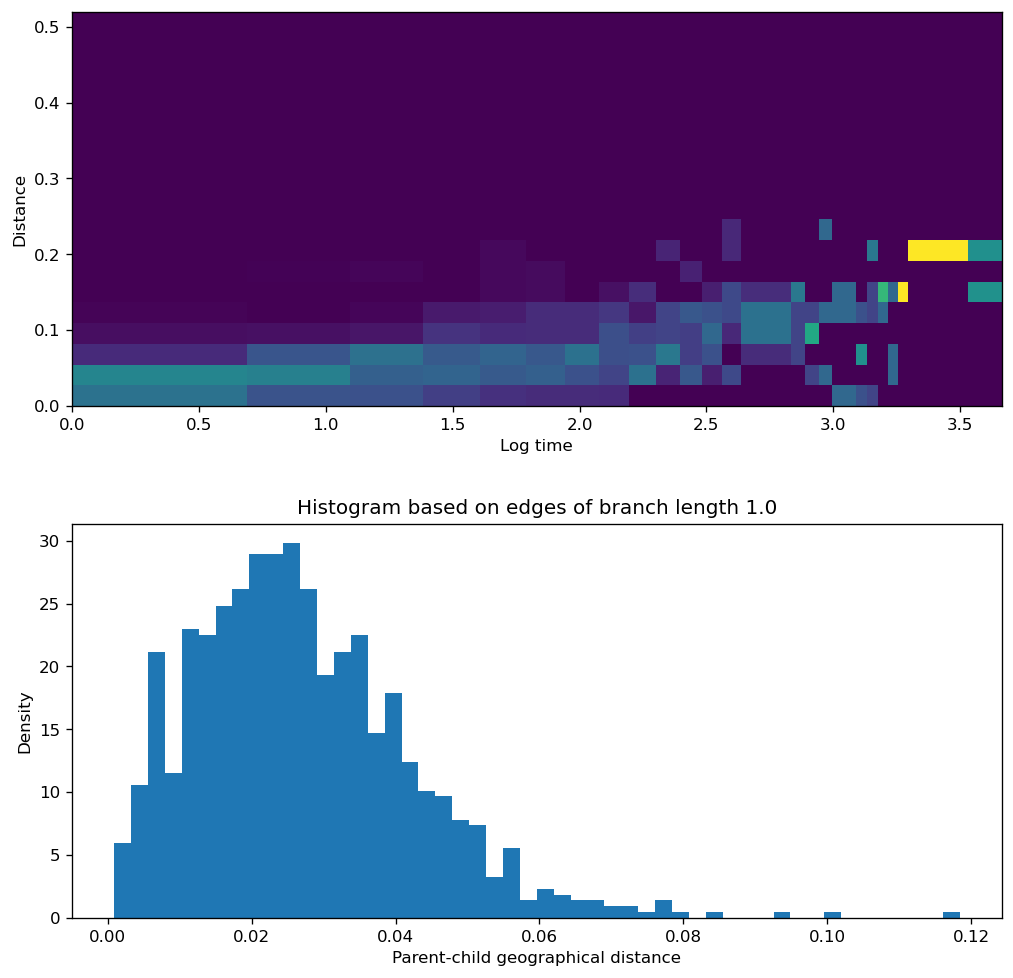

In [45]:
import tskit
import numpy as np
import collections
import matplotlib.pyplot as plt

ts = tskit.load("spatial_sim.trees")
distances = collections.defaultdict(list)
locations = ts.tables.individuals.location.reshape(-1, 3)
for e in ts.edges():
    parent = ts.node(e.parent)
    child = ts.node(e.child)
#     distances[parent.time - child.time].append(np.sqrt(np.sum(locations[parent.individual, 0:2] ** 2)))
    distances[parent.time - child.time].append(
        np.sqrt(np.sum((locations[parent.individual, 0:2] - locations[child.individual, 0:2]) ** 2)))

    
# turn into log times, and don't show the really long branches (large time deltas)
distances = {np.log(time):v for time, v in distances.items() if time < 40}

max_distance = max(max(d) for d in distances.values())
bins = np.linspace(0, max_distance, 20)
h = np.array([np.histogram(v, bins=bins, density=True)[0] for v in distances.values()])

fig, (ax0, ax1) = plt.subplots(2, figsize=(10, 10))
plt.subplots_adjust(hspace = 0.3)
ax0.pcolormesh(
    [0] + [k for k in distances.keys()],
    bins,
    h.T)
ax0.set_xlabel("Log time")
ax0.set_ylabel("Distance")
smallest_log_dist = min(distances.keys())
ax1.hist(distances[smallest_log_dist], density=True, bins=50)
ax1.set_title(f"Histogram based on edges of branch length {np.exp(smallest_log_dist)}")
ax1.set_xlabel("Parent-child geographical distance")
ax1.set_ylabel("Density")
plt.show()

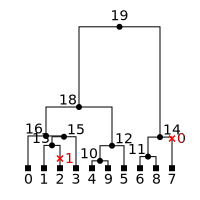

In [43]:

from IPython.display import SVG
SVG(ts_simp.first().draw())

In [40]:
ts_simp = ts.simplify(np.arange(0,10))

In [ ]:
# One way is to save all the individuals, so every edge should have be of length 1


In [ ]:
class Model:
    def __init__(self, ts_stuff):
        # Precompute an average-of-children baseline.
        baseline_0 = torch.zeros(num_internal_nodes)  # constant part
        baseline_1 = torch.zeros(num_internal_nodes, num_internal_nodes)  # linear part
        parents = ts.tables.edges.parent
        children = ts.tables.edges.child
        for ancestor in range(num_internal_nodes):  # ordered in time, latest to earliest
            children = children[parents==ancestor]
            for child in children:  # i.e. is leaf
                if ts_stuff.is_observed(child):
                    baseline_0[ancestor] += observed_pos[child]
                else:
                    baseline_0[ancestor] += baseline_0[child]
                    baseline_1[ancestor, :] += baseline_1[child, :]
            baseline_0[ancestor] /= len(children)
            baseline_1[ancestor] /= len(children)
        self.baseline = baseline_0, baseline_1
